### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets #context是word,targets是上下一個word

(array([7, 1, 0, 3, 5, 4]),
 array([[6, 1],
        [7, 0],
        [1, 3],
        [0, 5],
        [3, 4],
        [5, 2]]))

In [3]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0]]),
 array([[[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]]]))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

  5%|███▊                                                                           | 48/1000 [00:00<00:02, 464.47it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.159074027944586
Epoch: 2, Iteration: 1/2, Loss: 4.1588080031338635
Epoch: 3, Iteration: 1/2, Loss: 4.158909878205554
Epoch: 4, Iteration: 1/2, Loss: 4.158926683745989
Epoch: 5, Iteration: 1/2, Loss: 4.15880795115136
Epoch: 6, Iteration: 1/2, Loss: 4.1587828626106464
Epoch: 7, Iteration: 1/2, Loss: 4.158794839122095
Epoch: 8, Iteration: 1/2, Loss: 4.158619470848961
Epoch: 9, Iteration: 1/2, Loss: 4.158580565123341
Epoch: 10, Iteration: 1/2, Loss: 4.158698623150226
Epoch: 11, Iteration: 1/2, Loss: 4.158473080667029
Epoch: 12, Iteration: 1/2, Loss: 4.158592326179356
Epoch: 13, Iteration: 1/2, Loss: 4.158653460346009
Epoch: 14, Iteration: 1/2, Loss: 4.1582242579414554
Epoch: 15, Iteration: 1/2, Loss: 4.158494657713346
Epoch: 16, Iteration: 1/2, Loss: 4.158081849773817
Epoch: 17, Iteration: 1/2, Loss: 4.158555104165043
Epoch: 18, Iteration: 1/2, Loss: 4.158282790855557
Epoch: 19, Iteration: 1/2, Loss: 4.157866254687652
Epoch: 20, Iteration: 1/2, Loss: 4.158

 16%|████████████                                                                  | 155/1000 [00:00<00:01, 462.63it/s]

Epoch: 101, Iteration: 1/2, Loss: 2.6450662946188297
Epoch: 102, Iteration: 1/2, Loss: 2.8710977327520046
Epoch: 103, Iteration: 1/2, Loss: 3.072311149185632
Epoch: 104, Iteration: 1/2, Loss: 2.6421157736792793
Epoch: 105, Iteration: 1/2, Loss: 2.8791010365129113
Epoch: 106, Iteration: 1/2, Loss: 2.638989701868379
Epoch: 107, Iteration: 1/2, Loss: 2.3434157690890043
Epoch: 108, Iteration: 1/2, Loss: 2.703232238666736
Epoch: 109, Iteration: 1/2, Loss: 2.4418115472005826
Epoch: 110, Iteration: 1/2, Loss: 2.531111358401378
Epoch: 111, Iteration: 1/2, Loss: 2.7062561767547137
Epoch: 112, Iteration: 1/2, Loss: 2.408379200022325
Epoch: 113, Iteration: 1/2, Loss: 2.1583232312717335
Epoch: 114, Iteration: 1/2, Loss: 2.6266902536257883
Epoch: 115, Iteration: 1/2, Loss: 2.0034786307418666
Epoch: 116, Iteration: 1/2, Loss: 2.5345563470949184
Epoch: 117, Iteration: 1/2, Loss: 2.2703359998201096
Epoch: 118, Iteration: 1/2, Loss: 2.0932001057848657
Epoch: 119, Iteration: 1/2, Loss: 2.160035108633928

 26%|████████████████████▏                                                         | 259/1000 [00:00<00:01, 488.52it/s]

Epoch: 180, Iteration: 1/2, Loss: 1.5165034912357103
Epoch: 181, Iteration: 1/2, Loss: 1.501296000978038
Epoch: 182, Iteration: 1/2, Loss: 1.5030797812151824
Epoch: 183, Iteration: 1/2, Loss: 1.5083938090110163
Epoch: 184, Iteration: 1/2, Loss: 1.4857788278989066
Epoch: 185, Iteration: 1/2, Loss: 1.4925758827053577
Epoch: 186, Iteration: 1/2, Loss: 1.515532041355451
Epoch: 187, Iteration: 1/2, Loss: 1.4807231366365134
Epoch: 188, Iteration: 1/2, Loss: 1.4897681815454473
Epoch: 189, Iteration: 1/2, Loss: 1.4946232330143088
Epoch: 190, Iteration: 1/2, Loss: 1.469238540686878
Epoch: 191, Iteration: 1/2, Loss: 1.4993769686422582
Epoch: 192, Iteration: 1/2, Loss: 1.4845272840037596
Epoch: 193, Iteration: 1/2, Loss: 1.485820132967456
Epoch: 194, Iteration: 1/2, Loss: 1.4588596190684002
Epoch: 195, Iteration: 1/2, Loss: 1.4808550579158895
Epoch: 196, Iteration: 1/2, Loss: 1.491244153850666
Epoch: 197, Iteration: 1/2, Loss: 1.4668817595332
Epoch: 198, Iteration: 1/2, Loss: 1.4870524789750093
E

 31%|████████████████████████                                                      | 308/1000 [00:00<00:01, 426.15it/s]

Epoch: 275, Iteration: 1/2, Loss: 1.4202031475124102
Epoch: 276, Iteration: 1/2, Loss: 1.421705457244887
Epoch: 277, Iteration: 1/2, Loss: 1.4169880848388545
Epoch: 278, Iteration: 1/2, Loss: 1.4201608105013883
Epoch: 279, Iteration: 1/2, Loss: 1.4251663895407696
Epoch: 280, Iteration: 1/2, Loss: 1.416661448931646
Epoch: 281, Iteration: 1/2, Loss: 1.4189923241144293
Epoch: 282, Iteration: 1/2, Loss: 1.4181247638152974
Epoch: 283, Iteration: 1/2, Loss: 1.41946992368702
Epoch: 284, Iteration: 1/2, Loss: 1.4198321022798899
Epoch: 285, Iteration: 1/2, Loss: 1.420950118307412
Epoch: 286, Iteration: 1/2, Loss: 1.413928968563643
Epoch: 287, Iteration: 1/2, Loss: 1.4178889929321288
Epoch: 288, Iteration: 1/2, Loss: 1.4148808118885965
Epoch: 289, Iteration: 1/2, Loss: 1.4205664817714323
Epoch: 290, Iteration: 1/2, Loss: 1.4172361046915234
Epoch: 291, Iteration: 1/2, Loss: 1.4156449686046775
Epoch: 292, Iteration: 1/2, Loss: 1.4176883455234448
Epoch: 293, Iteration: 1/2, Loss: 1.4162641645415097

 41%|████████████████████████████████▏                                             | 413/1000 [00:00<00:01, 458.17it/s]

Epoch: 348, Iteration: 1/2, Loss: 1.405517138330199
Epoch: 349, Iteration: 1/2, Loss: 1.4069349312564072
Epoch: 350, Iteration: 1/2, Loss: 1.4052016792268998
Epoch: 351, Iteration: 1/2, Loss: 1.4097522834688196
Epoch: 352, Iteration: 1/2, Loss: 1.4069793471832788
Epoch: 353, Iteration: 1/2, Loss: 1.4048204152878077
Epoch: 354, Iteration: 1/2, Loss: 1.4081324298756954
Epoch: 355, Iteration: 1/2, Loss: 1.4059887702684204
Epoch: 356, Iteration: 1/2, Loss: 1.4029432166264568
Epoch: 357, Iteration: 1/2, Loss: 1.4077733801967334
Epoch: 358, Iteration: 1/2, Loss: 1.4063651027799602
Epoch: 359, Iteration: 1/2, Loss: 1.404160163515344
Epoch: 360, Iteration: 1/2, Loss: 1.40548306387285
Epoch: 361, Iteration: 1/2, Loss: 1.4091256610501701
Epoch: 362, Iteration: 1/2, Loss: 1.4035794539197939
Epoch: 363, Iteration: 1/2, Loss: 1.4040224404649813
Epoch: 364, Iteration: 1/2, Loss: 1.4071638921320104
Epoch: 365, Iteration: 1/2, Loss: 1.404987203360152
Epoch: 366, Iteration: 1/2, Loss: 1.405425321651398

 53%|█████████████████████████████████████████                                     | 526/1000 [00:01<00:00, 493.06it/s]

Epoch: 434, Iteration: 1/2, Loss: 1.39879693825306
Epoch: 435, Iteration: 1/2, Loss: 1.4003730190604533
Epoch: 436, Iteration: 1/2, Loss: 1.3986492712019838
Epoch: 437, Iteration: 1/2, Loss: 1.4019861675640632
Epoch: 438, Iteration: 1/2, Loss: 1.3998146589382878
Epoch: 439, Iteration: 1/2, Loss: 1.3985945213521767
Epoch: 440, Iteration: 1/2, Loss: 1.3996209830345605
Epoch: 441, Iteration: 1/2, Loss: 1.3999321884206155
Epoch: 442, Iteration: 1/2, Loss: 1.4003204586291247
Epoch: 443, Iteration: 1/2, Loss: 1.3988314055267907
Epoch: 444, Iteration: 1/2, Loss: 1.39840513495621
Epoch: 445, Iteration: 1/2, Loss: 1.3995543025857877
Epoch: 446, Iteration: 1/2, Loss: 1.400105959170201
Epoch: 447, Iteration: 1/2, Loss: 1.3992845397065166
Epoch: 448, Iteration: 1/2, Loss: 1.3996697357371501
Epoch: 449, Iteration: 1/2, Loss: 1.3992398416625962
Epoch: 450, Iteration: 1/2, Loss: 1.397941705432189
Epoch: 451, Iteration: 1/2, Loss: 1.4000108930859687
Epoch: 452, Iteration: 1/2, Loss: 1.39930261614836
E

 58%|████████████████████████████████████████████▉                                 | 576/1000 [00:01<00:00, 491.00it/s]

Epoch: 533, Iteration: 1/2, Loss: 1.3959819229707722
Epoch: 534, Iteration: 1/2, Loss: 1.3953252660888125
Epoch: 535, Iteration: 1/2, Loss: 1.3965249444384824
Epoch: 536, Iteration: 1/2, Loss: 1.3958276144722337
Epoch: 537, Iteration: 1/2, Loss: 1.3953338986075963
Epoch: 538, Iteration: 1/2, Loss: 1.3957356857852146
Epoch: 539, Iteration: 1/2, Loss: 1.397217844463887
Epoch: 540, Iteration: 1/2, Loss: 1.3948957262549797
Epoch: 541, Iteration: 1/2, Loss: 1.396034785919152
Epoch: 542, Iteration: 1/2, Loss: 1.3948458143920073
Epoch: 543, Iteration: 1/2, Loss: 1.3957583717953255
Epoch: 544, Iteration: 1/2, Loss: 1.3961867237196586
Epoch: 545, Iteration: 1/2, Loss: 1.3958173340203317
Epoch: 546, Iteration: 1/2, Loss: 1.395591364509428
Epoch: 547, Iteration: 1/2, Loss: 1.3955156414533831
Epoch: 548, Iteration: 1/2, Loss: 1.3956159140568671
Epoch: 549, Iteration: 1/2, Loss: 1.3955815295815746
Epoch: 550, Iteration: 1/2, Loss: 1.3953819606849975
Epoch: 551, Iteration: 1/2, Loss: 1.3954872910897

 68%|█████████████████████████████████████████████████████▎                        | 684/1000 [00:01<00:00, 493.47it/s]


Epoch: 630, Iteration: 1/2, Loss: 1.393821415993067
Epoch: 631, Iteration: 1/2, Loss: 1.393665153153311
Epoch: 632, Iteration: 1/2, Loss: 1.3935759447006584
Epoch: 633, Iteration: 1/2, Loss: 1.3937576385074946
Epoch: 634, Iteration: 1/2, Loss: 1.3935848610684252
Epoch: 635, Iteration: 1/2, Loss: 1.3932374711374038
Epoch: 636, Iteration: 1/2, Loss: 1.393914413868405
Epoch: 637, Iteration: 1/2, Loss: 1.3937971274658714
Epoch: 638, Iteration: 1/2, Loss: 1.3934998585645375
Epoch: 639, Iteration: 1/2, Loss: 1.393588528887892
Epoch: 640, Iteration: 1/2, Loss: 1.3933876093052717
Epoch: 641, Iteration: 1/2, Loss: 1.3937244208944182
Epoch: 642, Iteration: 1/2, Loss: 1.393431501406086
Epoch: 643, Iteration: 1/2, Loss: 1.3939787061951594
Epoch: 644, Iteration: 1/2, Loss: 1.3934421808357067
Epoch: 645, Iteration: 1/2, Loss: 1.3929982306413045
Epoch: 646, Iteration: 1/2, Loss: 1.3933780593834442
Epoch: 647, Iteration: 1/2, Loss: 1.3934316226906978
Epoch: 648, Iteration: 1/2, Loss: 1.39396980553951

 80%|██████████████████████████████████████████████████████████████▏               | 798/1000 [00:01<00:00, 505.39it/s]

Epoch: 725, Iteration: 1/2, Loss: 1.3919286938698752
Epoch: 726, Iteration: 1/2, Loss: 1.3926507813354545
Epoch: 727, Iteration: 1/2, Loss: 1.3919883112419753
Epoch: 728, Iteration: 1/2, Loss: 1.3924892041645827
Epoch: 729, Iteration: 1/2, Loss: 1.3923877111827772
Epoch: 730, Iteration: 1/2, Loss: 1.3920944192468454
Epoch: 731, Iteration: 1/2, Loss: 1.3923246132201723
Epoch: 732, Iteration: 1/2, Loss: 1.3918011572826519
Epoch: 733, Iteration: 1/2, Loss: 1.392617911766489
Epoch: 734, Iteration: 1/2, Loss: 1.3921157766268615
Epoch: 735, Iteration: 1/2, Loss: 1.3925944255827838
Epoch: 736, Iteration: 1/2, Loss: 1.3918573954800468
Epoch: 737, Iteration: 1/2, Loss: 1.391733303128266
Epoch: 738, Iteration: 1/2, Loss: 1.392405576251882
Epoch: 739, Iteration: 1/2, Loss: 1.3923184008291207
Epoch: 740, Iteration: 1/2, Loss: 1.3920352022884255
Epoch: 741, Iteration: 1/2, Loss: 1.3920862940491463
Epoch: 742, Iteration: 1/2, Loss: 1.3921419090352503
Epoch: 743, Iteration: 1/2, Loss: 1.3916238721477

 91%|██████████████████████████████████████████████████████████████████████▊       | 908/1000 [00:01<00:00, 510.08it/s]

Epoch: 817, Iteration: 1/2, Loss: 1.3912783292931783
Epoch: 818, Iteration: 1/2, Loss: 1.3914512946225417
Epoch: 819, Iteration: 1/2, Loss: 1.39087950496477
Epoch: 820, Iteration: 1/2, Loss: 1.3916591179839934
Epoch: 821, Iteration: 1/2, Loss: 1.39132394519314
Epoch: 822, Iteration: 1/2, Loss: 1.3912173075776555
Epoch: 823, Iteration: 1/2, Loss: 1.3913105464761535
Epoch: 824, Iteration: 1/2, Loss: 1.3913095237743704
Epoch: 825, Iteration: 1/2, Loss: 1.391234608930474
Epoch: 826, Iteration: 1/2, Loss: 1.390989638742028
Epoch: 827, Iteration: 1/2, Loss: 1.3914620411107208
Epoch: 828, Iteration: 1/2, Loss: 1.3910198700192917
Epoch: 829, Iteration: 1/2, Loss: 1.3911552526810884
Epoch: 830, Iteration: 1/2, Loss: 1.3915075367647294
Epoch: 831, Iteration: 1/2, Loss: 1.3912104163773744
Epoch: 832, Iteration: 1/2, Loss: 1.391236806636743
Epoch: 833, Iteration: 1/2, Loss: 1.3912007935688129
Epoch: 834, Iteration: 1/2, Loss: 1.3911585227328445
Epoch: 835, Iteration: 1/2, Loss: 1.391461390931824
E

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 486.77it/s]

Epoch: 911, Iteration: 1/2, Loss: 1.3908535630257166
Epoch: 912, Iteration: 1/2, Loss: 1.3903856343839316
Epoch: 913, Iteration: 1/2, Loss: 1.3908572896502545
Epoch: 914, Iteration: 1/2, Loss: 1.3900065975439637
Epoch: 915, Iteration: 1/2, Loss: 1.3908906794610731
Epoch: 916, Iteration: 1/2, Loss: 1.3905738940524
Epoch: 917, Iteration: 1/2, Loss: 1.3905445098587694
Epoch: 918, Iteration: 1/2, Loss: 1.390561047165179
Epoch: 919, Iteration: 1/2, Loss: 1.390772308696663
Epoch: 920, Iteration: 1/2, Loss: 1.3903528580526048
Epoch: 921, Iteration: 1/2, Loss: 1.390735804064867
Epoch: 922, Iteration: 1/2, Loss: 1.3900769999607023
Epoch: 923, Iteration: 1/2, Loss: 1.3905524114291001
Epoch: 924, Iteration: 1/2, Loss: 1.3906673090774855
Epoch: 925, Iteration: 1/2, Loss: 1.3903713341264856
Epoch: 926, Iteration: 1/2, Loss: 1.3904867544220054
Epoch: 927, Iteration: 1/2, Loss: 1.3907125376214293
Epoch: 928, Iteration: 1/2, Loss: 1.3904963225232092
Epoch: 929, Iteration: 1/2, Loss: 1.3907333137396294

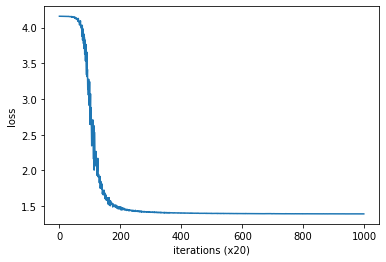

In [6]:
trainer.plot()

In [7]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

natural [ 0.16589083 -2.236172   -1.5839291   0.6988937  -1.3915342 ]
studying [ 1.1796643   1.7634431   1.7227309   0.58583415 -0.5138855 ]
. [-0.00439008  0.00923975 -0.00680103 -0.02705207 -0.01214297]
language [-0.09813242  1.4367162   1.5380844  -0.90099937  2.039908  ]
now [-1.6882036  -0.38495916 -0.43559682 -1.5338247   1.6015465 ]
processing [ 0.0869865  -1.959536    0.82959706  1.8407598   0.41483608]
i [-0.00700054 -0.02036355 -0.00430416  0.01152475 -0.00137651]
am [ 0.28105742  0.6135118  -2.1624184  -0.72468585 -1.5795735 ]
